# Multihead Attention

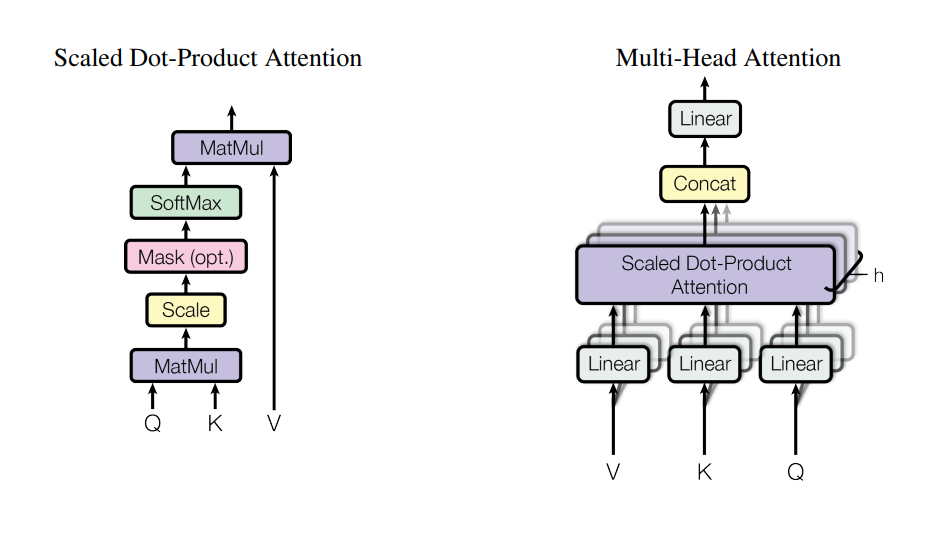

In [ ]:
# Multi-Head Attention에서는 Linear를 통해 임의의 가중치를 곱한 가중합을 사용하기 때문에 Q, K, V의 벡터값은 서로 같지 않다.(출처가 같다.)
# w1 * x1 + w2 * x2...... + w512 * x512 : 가중치 갯수가 512^2 개
W_Q, W_K, W_V = nn.Linear(hidden_size, 8 * 64), nn.Linear(hidden_size, 8*64), nn.Linear(hidden_size, 8*64) #hidden_size, N_multihead, dk

In [ ]:
q_s, k_s, v_s = W_Q(Q), W_Q(K), W_Q(V)

In [ ]:
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 9, 512]) torch.Size([2, 9, 512]) torch.Size([2, 9, 512])


In [ ]:
q_s.size()

torch.Size([2, 9, 512])

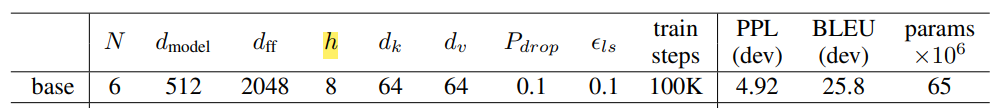

In [ ]:
# multihead 개수만큼 나누기 (논문에 의하면 multihead 개수는 8개)
# 두 문장에 9개의 토큰에 대한 512개의 임베딩을 8묶음으로 나눈다. => '어제' 라는 단어의 512개 임베딩을 먼저 64개씩 8개로 묶고 이를 나눈 것
q_s, k_s, v_s = q_s.view(Q.size(0), -1, 8, 64), k_s.view(K.size(0), -1, 8, 64), v_s.view(V.size(0), -1, 8, 64)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 9, 8, 64]) torch.Size([2, 9, 8, 64]) torch.Size([2, 9, 8, 64])


In [ ]:
# 각 동일하게 [2, 8, 9, 9]의 형태로 바꿔준다.
attention_mask.size()

torch.Size([2, 9, 9])

In [ ]:
attention_mask.unsqueeze(1).repeat(1, 8, 1, 1).size()

torch.Size([2, 8, 9, 9])

In [ ]:
attention_mask

tensor([[[False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False]],

        [[False, False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False, False,  True,  True],
         [False, False, False, False

In [ ]:
# Q, K matmul
# transpose를 통해 [2, 9, 8, 64]에서 [2, 8, 9, 64]로 행렬 크기를 변경한다.
# 바꾸기 이전이 각 토큰을 64차원의 vector를 8묶음으로 묶은 것이고, 이후는 8개 묶음 안에 64차원의 vector가 9개씩 존재
# 그림필요
# 1번 멀티 헤드 = ['어제', '카페', '갔', '##었어', '거기', '사람', '많더라']에 대한 임베딩이 64개씩 존재하는 것 
# 즉 문장별 9개 token에 대한 64차원의 임베딩이 8개씩 존재
print(q_s.transpose(1,2).size(), k_s.transpose(1,2).transpose(-1, -2).size())
mh_score = torch.matmul(q_s.transpose(1,2), k_s.transpose(1,2).transpose(-1, -2))
print(mh_score.size())

torch.Size([2, 8, 9, 64]) torch.Size([2, 8, 64, 9])
torch.Size([2, 8, 9, 9])


In [ ]:
# mask
# 마지막 2개는 0처리 된 것을 볼 수 있다.
mh_score = mh_score.masked_fill(attention_mask.unsqueeze(1).repeat(1, 8, 1, 1), 0)
print(mh_score[1][3], mh_score.size())

tensor([[27.2898,  9.0917, 14.0805, 13.8403,  2.1830, 12.1564, 10.2985,  0.0000,
          0.0000],
        [ 9.0917, 22.4628, 11.4609, 13.7078,  9.4371,  8.0655, 11.7415,  0.0000,
          0.0000],
        [14.0805, 11.4609, 30.1133, 16.9165,  8.4768, 12.8048, 12.2948,  0.0000,
          0.0000],
        [13.8403, 13.7078, 16.9165, 30.7009, 12.9080, 14.1932,  9.7008,  0.0000,
          0.0000],
        [ 2.1830,  9.4371,  8.4768, 12.9080, 32.8352,  6.4613,  7.8335,  0.0000,
          0.0000],
        [12.1564,  8.0655, 12.8048, 14.1932,  6.4613, 29.0713, 12.3553,  0.0000,
          0.0000],
        [10.2985, 11.7415, 12.2948,  9.7008,  7.8335, 12.3553, 40.6605,  0.0000,
          0.0000],
        [ 4.0540,  8.7772,  5.7486,  8.7212, 14.8044,  9.5058, 12.6439,  0.0000,
          0.0000],
        [ 3.6369,  8.1204,  5.3513,  7.0364, 13.9188,  8.6799, 11.8009,  0.0000,
          0.0000]], grad_fn=<SelectBackward0>) torch.Size([2, 8, 9, 9])


In [ ]:
# Scale
mh_score = mh_score/(64 ** 0.5)
print(mh_score[0][0], mh_score.size())

tensor([[3.8110, 2.2095, 1.3545, 2.2863, 1.7958, 1.5937, 1.3150, 2.1016, 1.5665],
        [2.2095, 5.5694, 3.2310, 2.3349, 1.3718, 1.0359, 1.7609, 2.2526, 2.1200],
        [1.3545, 3.2310, 4.9884, 2.0594, 0.9642, 0.7244, 1.8707, 1.8392, 1.3262],
        [2.2863, 2.3349, 2.0594, 4.2065, 1.5017, 1.7286, 1.1541, 1.7152, 1.3259],
        [1.7958, 1.3718, 0.9642, 1.5017, 3.8033, 1.1776, 1.2449, 2.1710, 0.6046],
        [1.5937, 1.0359, 0.7244, 1.7286, 1.1776, 4.4907, 2.3849, 2.7513, 1.4320],
        [1.3150, 1.7609, 1.8707, 1.1541, 1.2449, 2.3849, 4.1034, 2.3321, 2.2757],
        [2.1016, 2.2526, 1.8392, 1.7152, 2.1710, 2.7513, 2.3321, 5.3173, 1.6299],
        [1.5665, 2.1200, 1.3262, 1.3259, 0.6046, 1.4320, 2.2757, 1.6299, 4.8940]],
       grad_fn=<SelectBackward0>) torch.Size([2, 8, 9, 9])


In [ ]:
# SoftMax
sf_mh_score = nn.Softmax(dim = -1)(mh_score)
print(sf_mh_score[0][0], sf_mh_score.size())

tensor([[0.4725, 0.0952, 0.0405, 0.1028, 0.0630, 0.0515, 0.0389, 0.0855, 0.0501],
        [0.0270, 0.7772, 0.0750, 0.0306, 0.0117, 0.0084, 0.0172, 0.0282, 0.0247],
        [0.0189, 0.1235, 0.7158, 0.0383, 0.0128, 0.0101, 0.0317, 0.0307, 0.0184],
        [0.0836, 0.0877, 0.0666, 0.5700, 0.0381, 0.0478, 0.0269, 0.0472, 0.0320],
        [0.0760, 0.0498, 0.0331, 0.0567, 0.5660, 0.0410, 0.0438, 0.1106, 0.0231],
        [0.0355, 0.0203, 0.0149, 0.0406, 0.0234, 0.6436, 0.0784, 0.1130, 0.0302],
        [0.0326, 0.0510, 0.0569, 0.0278, 0.0304, 0.0951, 0.5306, 0.0903, 0.0853],
        [0.0299, 0.0348, 0.0230, 0.0203, 0.0321, 0.0573, 0.0377, 0.7461, 0.0187],
        [0.0274, 0.0476, 0.0215, 0.0215, 0.0105, 0.0239, 0.0556, 0.0292, 0.7628]],
       grad_fn=<SelectBackward0>) torch.Size([2, 8, 9, 9])


In [ ]:
# v_s와 matmul
# (문장 개수, multihead 개수, token 개수, vector 개수)
context = torch.matmul(sf_mh_score, v_s.view(2, 8, 9, 64))
print(context[0][0][0], context.size())

tensor([ 0.2746,  0.5771, -0.4573, -0.3059, -0.2359,  0.1486,  0.2097, -0.1064,
         0.0041,  0.1733,  0.1593, -0.8057,  0.8108, -0.2441,  0.0075,  0.2324,
         0.0624, -0.2965, -0.0709,  0.0994,  0.7231,  0.0014,  0.2071, -0.0945,
        -0.7493,  0.0029,  0.4336, -0.4551, -0.3034,  0.2328, -0.2100,  0.0898,
        -0.5024,  0.2507,  0.0614, -0.3386,  1.1465, -0.0548,  0.2608, -0.2270,
        -0.0374,  0.0580,  0.3116,  0.0508,  0.7737, -0.0112,  0.2120, -0.2228,
        -0.3061,  0.4085,  0.0279,  0.5197, -0.0534,  0.2913, -0.0910,  0.1013,
         0.3767, -0.1957,  0.3073, -0.3370,  0.0832,  0.3363,  0.0896,  0.4667],
       grad_fn=<SelectBackward0>) torch.Size([2, 8, 9, 64])


In [ ]:
# concat(input과 크기가 똑같도록 바꾼다. [2, 9, 512])
cc_context = context.transpose(2, 1).contiguous().view(2, 9, 512)
print(cc_context[0], cc_context.size())

tensor([[ 0.2746,  0.5771, -0.4573,  ..., -0.2340, -0.1107, -0.2459],
        [ 0.2323,  0.1263,  0.7423,  ...,  0.5754,  0.6054,  0.1793],
        [ 0.0493, -0.7693,  0.1010,  ...,  0.3772,  0.2468,  0.5872],
        ...,
        [ 0.1535,  0.2047, -0.4777,  ...,  0.7060,  0.5387, -0.3120],
        [-0.4438,  0.2987,  0.9846,  ..., -0.4238,  0.2564,  0.1519],
        [ 0.8614,  0.3104, -1.4468,  ..., -1.0316, -0.0649,  0.5543]],
       grad_fn=<SelectBackward0>) torch.Size([2, 9, 512])


In [ ]:
# Linear
# hidden_size, h * 64
multihead_output = nn.Linear(512, 512)(cc_context)
print(multihead_output, multihead_output.size())

tensor([[[-0.0280, -0.4293,  0.0111,  ..., -0.1509, -0.2081,  0.1158],
         [-0.0922,  0.4395,  0.1317,  ..., -0.0131, -0.4039,  0.2688],
         [-0.2359, -0.1284,  0.1234,  ..., -0.1862, -0.2266,  0.0352],
         ...,
         [ 0.0323, -0.0071, -0.1416,  ..., -0.0283, -0.0215, -0.1854],
         [-0.5008,  0.2516,  0.3206,  ..., -0.5678,  0.0386, -0.1324],
         [ 0.1839, -0.2604, -0.0166,  ..., -0.1668,  0.0536, -0.0183]],

        [[ 0.5730, -0.1667,  0.0677,  ...,  0.1445, -0.1412,  0.1338],
         [-0.4313,  0.3161,  0.1016,  ..., -0.1094, -0.9506,  0.1306],
         [-0.0783, -0.5693, -0.2106,  ...,  0.2957, -0.5479,  0.0679],
         ...,
         [ 0.2042,  0.0923, -0.2342,  ..., -0.0311, -0.2248, -0.0841],
         [ 0.1407, -0.0159, -0.0487,  ...,  0.0278, -0.3640,  0.0539],
         [ 0.1280, -0.0353, -0.0630,  ...,  0.0157, -0.3688,  0.0601]]],
       grad_fn=<ViewBackward0>) torch.Size([2, 9, 512])


# Mutihead Attention Define

In [ ]:
class SDPAD(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, Q, K, V, attention_mask):
    score = torch.matmul(Q, K.transpose(-1, -2))
    score = score / (64 ** 0.5)
    score = score.masked_fill(attention_mask, 0)
    attn_prob = nn.Softmax(dim=-1)(score)
    context = torch.matmul(attn_prob, V)
    return context, attn_prob

In [ ]:
# class를 이용하여 각 문장의 embedding 차원을 Multhead로 나눈 후
# Q, K를 곱하고 scale 후 pad token 값을 0으로 만든뒤 softmax 후 다시 V값과 곱하는
# 과정을 일원화
class Mutihead_attention(nn.Module):
  def __init__(self, hidden_size = 512, n_head = 8, d_men = 64):
    super().__init__()

    self.hidden_size = hidden_size
    self.n_head = n_head
    self.d_men = d_men
    self.linear = nn.Linear(hidden_size, n_head * d_men)

    self.W_Q = nn.Linear(hidden_size, n_head * d_men)
    self.W_K = nn.Linear(hidden_size, n_head * d_men)
    self.W_V = nn.Linear(hidden_size, n_head * d_men)
    self.scaled_dot = SDPAD()

  def forward(self, Q, K, V, attention_mask):
    batch_size = Q.size(0)
    q_s = W_Q(Q).view(batch_size, -1, self.n_head, self.d_men).transpose(1, 2)
    k_s = W_Q(K).view(batch_size, -1, self.n_head, self.d_men).transpose(1, 2)
    v_s = W_Q(V).view(batch_size, -1, self.n_head, self.d_men).transpose(1, 2)

    attention_m = attention_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

    context, attention_prob = self.scaled_dot(q_s, k_s, v_s, attention_m)
    context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_men)
    output = self.linear(context)

    return output, attention_prob

In [ ]:
ma = Mutihead_attention()

In [ ]:
ma(Q, K, V, attention_mask)[0].size()

torch.Size([2, 9, 512])